<a href="https://colab.research.google.com/github/PavleSavic/ML_project2023/blob/main/03_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
RANDOM_STATE=1234
np.random.seed(RANDOM_STATE)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from transformers import BertTokenizer, TFAutoModel

In [6]:
data = pd.read_csv('dataset/IMDB_Dataset.csv')

In [7]:
data.sentiment.replace("positive", 1, inplace = True)
data.sentiment.replace("negative", 0, inplace = True)

In [8]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [9]:
train_ds, test_ds = train_test_split(data, test_size=0.33, random_state=RANDOM_STATE,
                                     shuffle=True, stratify=data['sentiment'])

In [10]:
train_ds.shape, test_ds.shape

((33500, 2), (16500, 2))

## Preprocesiranje

In [11]:
seq_len = 512
num_samples = len(train_ds)

# inicijalizacija:
# token ids
Xids = np.zeros((num_samples, seq_len))
# attention mask
Xmask = np.zeros((num_samples, seq_len))

Xids.shape, Xmask.shape

((33500, 512), (33500, 512))

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [13]:
for i, review in enumerate(train_ds['review']):
    # odseca sve nakon 512. tokena, ako ih ima manje dopunjuje do 512 padding tokenima
    tokens = tokenizer.encode_plus(review, max_length=seq_len, truncation=True,
                                 padding='max_length', add_special_tokens=True,
                                 return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']
# special tokens:
# [CLS] - start of sequence, [SEP] - separator, [PAD] - padding token

In [14]:
Xids

array([[  101.,   128.,  1191., ...,     0.,     0.,     0.],
       [  101.,  1109.,  1642., ...,     0.,     0.,     0.],
       [  101.,  1448.,  1104., ...,     0.,     0.,     0.],
       ...,
       [  101.,  1188.,  1273., ...,     0.,     0.,     0.],
       [  101., 12008., 27788., ...,     0.,     0.,     0.],
       [  101.,   138.,  1662., ...,   133.,  9304.,   102.]])

In [15]:
# 1 - bert racuna attention za taj token, 0 - ne racuna
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [16]:
labels = train_ds['sentiment']
Xids.shape, Xmask.shape, labels.shape

((33500, 512), (33500, 512), (33500,))

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [18]:
Xids[0, :].shape, Xmask[0, :].shape

((512,), (512,))

In [19]:
# reformat
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [20]:
dataset = dataset.map(map_func)

In [21]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [22]:
batch_size = 16
dataset = dataset.shuffle(RANDOM_STATE).batch(batch_size, drop_remainder=True)

# za svaki tenzor sada imamo 16 instanci
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16,), dtype=tf.int64, name=None))>

In [23]:
# podela na trening i validacioni
split = 0.8
size = int((num_samples / batch_size) * split)

train_dataset = dataset.take(size)
val_dataset = dataset.skip(size)

## Konfigurisanje modela

In [24]:
# glavni model
bert = TFAutoModel.from_pretrained('bert-base-cased')
bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# ulazni slojevi
input_ids = Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = Input(shape=(seq_len,), name='attention_mask', dtype='int32')
                                                     # [0] - 3D tenzori
                                                     # [1] - uradjen pooling u 2D tenzore
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

x = Dense(units=1024, activation='relu') (embeddings)
# izlazni sloj - verovatnoca pozitivne klase
y = Dense(units=1, activation='sigmoid') (x)

In [26]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# zamrznuti parametri bert sloja (ograniceni resursi)
model.layers[2].trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

## Treniranje modela

In [27]:
model.compile(optimizer=Adam(learning_rate=1e-5, weight_decay=1e-6),
              loss=BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3, verbose=1)

Epoch 1/3
1675/1675 [==============================] - 1438s 853ms/step - loss: 0.6425 - accuracy: 0.6360 - val_loss: 0.6058 - val_accuracy: 0.6927
Epoch 2/3
1675/1675 [==============================] - 1427s 852ms/step - loss: 0.6042 - accuracy: 0.6834 - val_loss: 0.5808 - val_accuracy: 0.7032
Epoch 3/3
1675/1675 [==============================] - 1427s 852ms/step - loss: 0.5859 - accuracy: 0.6999 - val_loss: 0.5658 - val_accuracy: 0.7282


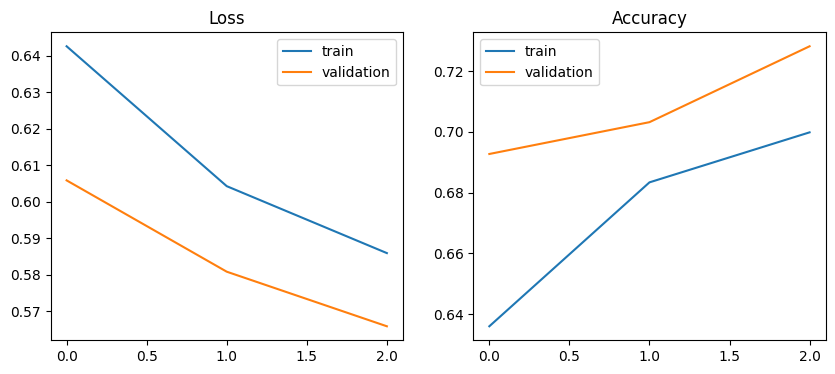

In [33]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, 3), history.history['loss'], label='train')
plt.plot(np.arange(0, 3), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, 3), history.history['accuracy'], label='train')
plt.plot(np.arange(0, 3), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

## Evaluacija modela

In [34]:
test_ds.head()

,review,sentiment
14746,The first film was quite hip and had amusing m...,0
28039,This first-rate western tale of the gold rush ...,1
21289,"In a near future, the ordinary man above any s...",1
12020,"A fine Martino outing, this is a spirited and ...",1
14208,ELEPHANT WALK may not be the acme of literatur...,1


In [35]:
# priprema formata
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512, truncation=True,
                                 padding='max_length', add_special_tokens=True,
                                 return_tensors='tf')
    return {
      'input_ids': tf.cast(tokens['input_ids'], tf.float64),
      'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)
    }

In [36]:
true_labels = test_ds['sentiment']
test_reviews = test_ds['review']

In [42]:
# napomena: zbog ogranicenih resursa nije iskoriscen ceo test skup za evaluaciju
# verovatnoce pozitivne klase
probs = []
i = 0
for review in test_reviews:
    if i > 3500:
        break
    prob = model.predict(prep_data(review))[0][0]
    probs.append(prob)
    i = i + 1

In [53]:
def sigmoid_to_label(x):
    if x<0.5:
        return 0
    return 1
    
predicted_labels = list(map(sigmoid_to_label, probs))

In [48]:
true_labels = true_labels[:3501]

In [57]:
# tacnost na test skupu
accuracy_score = metrics.accuracy_score(true_labels, predicted_labels)
print(accuracy_score)

0.7169380177092259


In [58]:
print(metrics.classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      1744
           1       0.75      0.65      0.70      1757

    accuracy                           0.72      3501
   macro avg       0.72      0.72      0.72      3501
weighted avg       0.72      0.72      0.72      3501



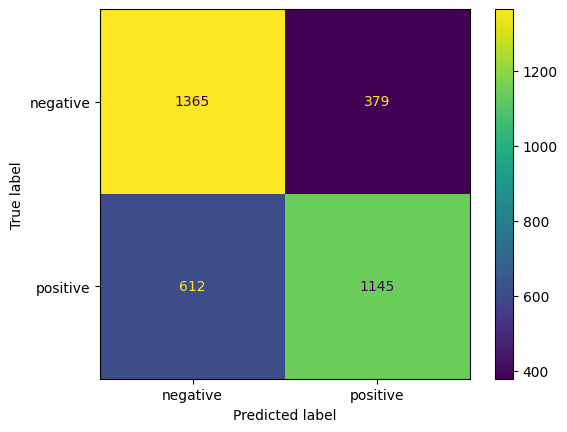

In [61]:
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['negative', 'positive'])
cm_display.plot()
plt.show()

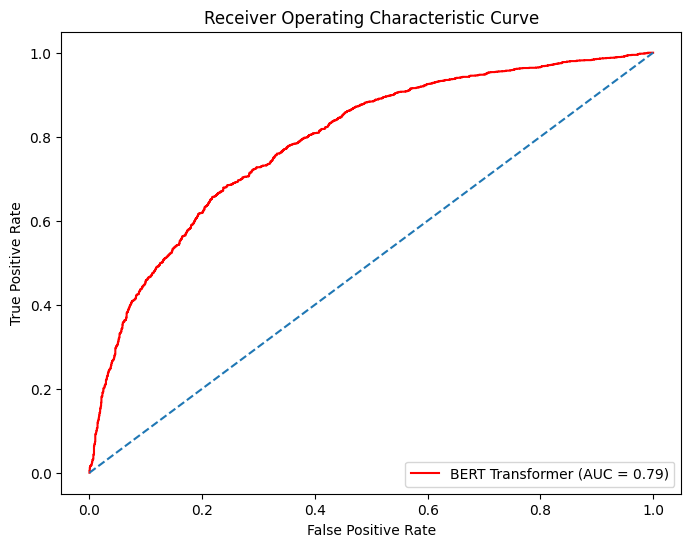

In [66]:
fpr, tpr, thresholds = metrics.roc_curve(true_labels, probs)
plt.figure(figsize=(8,6))
plt.title('Receiver Operating Characteristic Curve')
auc_score = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'BERT Transformer (AUC = {auc_score:.2f})')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Testiranje na novim podacima

In [69]:
new_reviews = ["This is super interesting and funny movie. Great casting",
               "Red Notice was a great movie! Very entertaining, I also loved the dynamic between the characters, it works really well. I like the stakes and all that takes place, I was genuinely surprised by parts of the movie in a good way! I look forward to and 100% want to see a sequel made for this great story",
               "I'm not sure what these high profile, talented actors were offered to involve themselves in such a mediocre film. Every plot point and twist seems to exist just to inject some sort of excitement into an increasingly boring narrative. There's no craftsmanship, half-assed foreshadowing, everything is just beat after beat of nonsensical thieving hijinks compounded on uninspired action set pieces. Red Notice is everything wrong with frivolous high budget action films that have little to no interest in making something remotely intelligent.",
               "It's lazy, barrel-scraping cinema at its worst."
              ]

In [71]:
sigmoids = []
for review in new_reviews:
    sigmoid = model.predict(prep_data(review))[0][0]
    sigmoids.append(sigmoid)

In [74]:
# dobro je predvideo (vidimo da je nesiguran za 1.)
print(sigmoids)
print(list(map(sigmoid_to_label, sigmoids)))

[0.5692211, 0.791578, 0.251394, 0.20800948]
[1, 1, 0, 0]
